In [1]:
#dependency
import os 
import json
import petpy
import urllib
import time
import pandas as pd

import time
from pprint import pprint

#database 
import sqlalchemy
from sqlalchemy import inspect
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base

#
from config import key, secret, api_key 
import config


In [ ]:


base_url = "http://api.giphy.com/v1/gifs/search?"

q = 'cat'

limit = '5'

offset = '100'

rating = 'g'

lang = 'en'

query_url = base_url + 'api_key='+ api_key + '&q='+ q + '&limit='+ limit + '&offset=' + offset + '&rating=' + rating + '&lang='+ lang
print(query_url)

In [ ]:
base_url = "http://api.giphy.com/v1/gifs/search?"

q = 'cat'

limit = '100'

offset = '100'

rating = 'g'

lang = 'en'

query_url = base_url + 'api_key='+ api_key + '&q='+ q + '&limit='+ limit + '&offset=' + offset + '&rating=' + rating + '&lang='+ lang
# print(query_url)

def response(query_url):
    with urllib.request.urlopen(query_url) as response:
        data = json.loads(response.read())
        
        #empty list
        gif_url = []
        slug = []
        gif_id = []
        trending_datetime= []

        #loop and append empty list
        for item in data['data']:
            
            gif_id.append(item['id'])
            slug.append(item['slug'])
            trending_datetime.append(item['trending_datetime'])
            gif_url.append(item['bitly_gif_url'])
        
            #create df for the list items (slug and gif_url)
            giphy_df = pd.DataFrame({'slug':slug,
                                    'gif_url':gif_url,'gif_id':gif_id,
                                    'trending_datetime':trending_datetime})

            #remove all the data with no trending dates by using drop dpulicates ('0000-00-00 00:00:00')
            giphy_df.drop_duplicates(subset ="trending_datetime",
                             keep = False, inplace = True)

            #reset index to gif_url
            giphy_df = giphy_df.set_index('gif_id')

        return giphy_df



response(query_url)



In [65]:

def getDailyStats():
    
    # Create a SQL Database connection
    connection_string = f"postgres:{config.password}@localhost:5432/pets_db"
    engine = create_engine(f'postgresql://{connection_string}')

    #check for connection to db and show all table names 
    engine.table_names()
    
    # reflect an existing database 
    Base = automap_base()

    # reflect the tables
    Base.prepare(engine, reflect=True)


    
    #---------Daily Stats-----------
    stats = engine.execute("""
    SELECT CAST(CAST(date_published AS date) AS varchar) AS trending_post_date, COUNT(species), species, search_type FROM 
(
    SELECT species, date_published, 'adoption' as search_type 
    FROM cat_post_db
    WHERE date_published >= '2021-01-01' AND date_published < '2021/04/18'
    UNION
	
    SELECT species, date_published, 'adoption' as search_type 
    FROM dog_post_db
    WHERE date_published >= '2021-01-01' AND date_published < '2021/04/18'
	
	UNION
	
	SELECT species , trending_datetime as date_published, 'giphy' as search_type
    FROM dog_giphy_db
    WHERE trending_datetime >= '2021-01-01' AND trending_datetime < '2021/04/18'
	
	UNION
	
	SELECT species , trending_datetime as date_published, 'giphy' as search_type
    FROM cat_giphy_db
    WHERE trending_datetime >= '2021-01-01' AND trending_datetime < '2021/04/18'
) AS sub
GROUP BY CAST(date_published AS date), species, search_type
ORDER BY CAST(date_published AS date)
    """).fetchall()


    
    return stats
    
   
    
getDailyStats()


[('2021-01-07', 1, 'Cat', 'giphy'),
 ('2021-01-16', 1, 'Cat', 'giphy'),
 ('2021-01-16', 1, 'Dog', 'giphy'),
 ('2021-01-19', 1, 'Cat', 'giphy'),
 ('2021-01-19', 1, 'Dog', 'giphy'),
 ('2021-01-25', 1, 'Dog', 'giphy'),
 ('2021-01-27', 1, 'Cat', 'giphy'),
 ('2021-01-27', 1, 'Dog', 'giphy'),
 ('2021-01-28', 1, 'Dog', 'giphy'),
 ('2021-01-29', 1, 'Cat', 'giphy'),
 ('2021-02-01', 1, 'Cat', 'giphy'),
 ('2021-02-02', 1, 'Dog', 'giphy'),
 ('2021-02-04', 1, 'Dog', 'giphy'),
 ('2021-02-07', 1, 'Cat', 'giphy'),
 ('2021-02-10', 1, 'Dog', 'giphy'),
 ('2021-02-11', 1, 'Cat', 'giphy'),
 ('2021-02-14', 1, 'Cat', 'giphy'),
 ('2021-02-17', 1, 'Dog', 'giphy'),
 ('2021-02-18', 1, 'Cat', 'giphy'),
 ('2021-02-20', 4, 'Dog', 'giphy'),
 ('2021-02-21', 1, 'Dog', 'giphy'),
 ('2021-02-28', 1, 'Dog', 'giphy'),
 ('2021-03-04', 1, 'Cat', 'giphy'),
 ('2021-03-05', 1, 'Dog', 'giphy'),
 ('2021-03-08', 1, 'Dog', 'giphy'),
 ('2021-03-12', 1, 'Cat', 'giphy'),
 ('2021-03-14', 1, 'Dog', 'giphy'),
 ('2021-03-19', 1, 'Cat', 'g

IndentationError: unexpected indent (<ipython-input-42-62ceae0d8170>, line 2)

In [71]:
import pandas as pd
from datetime import datetime

#list of data ranges 
lst_dt = pd.date_range(start="2021-01-01",end="2021/04/18")

date_list = []
cat_post_list = []
dog_post_list = []
cat_giphy_list = []
dog_giphy_list = []

date_dict = {}

for d in lst_dt:
    date_list.append(d.date())
    date_dict[str(d.date())] = [0, 0, 0, 0]

#retrieve data func getDailyStats()
daily_stats = getDailyStats()

for column in daily_stats:
    stat_date = str(column[0])
    stat_count = column[1]
    stat_species = column[2]
    stat_search_type = column[3]
    
    if stat_search_type == 'adoption':
        if stat_species == 'Cat':
            date_dict[stat_d][0] = stat_c
        elif stat_species == 'Dog':
            date_dict[stat_d][1] = stat_c
    elif stat_search_type == 'giphy':
        if stat_species == 'Cat':
            date_dict[stat_d][2] = stat_c
        elif stat_species == 'Dog':
            date_dict[stat_d][3] = stat_c

for d in date_dict.keys():
    counts = date_dict[d]
    cat_post_list.append(counts[0])
    dog_post_list.append(counts[1])
    cat_giphy_list.append(counts[2])
    dog_giphy_list.append(counts[3])
    

date_list = [str(x) for x in date_list]

# print(len(date_list))
# print(len(cat_post_list))
# print(len(dog_post_list))
# print(len(cat_giphy_list))
# print(len(dog_giphy_list))

# print(date_list)
# print(cat_post_list)
# print(dog_post_list)
# print(cat_giphy_list)
# print(dog_giphy_list)
    
daily_stats_df = pd.DataFrame({'date': date_list,
                           'cat_adoption': cat_post_list,
                           'dog_adoption':dog_post_list,
                           'cat_post':cat_giphy_list,
                           'dog_post':dog_giphy_list
                          })

daily_stats_df = daily_stats_df.set_index('date') 
daily_stats_df.to_csv('Stats_output.csv')
    

In [79]:
daily_stats_df = pd.DataFrame({'date': date_list,
                               'cat_adoption': cat_post_list,
                               'dog_adoption':dog_post_list,
                               'cat_post':cat_giphy_list,
                               'dog_post':dog_giphy_list
                              })

daily_stats_df = daily_stats_df.set_index('date')



In [ ]:


fig = plt.figure()
ax = df[['cat_adoption','dog_adoption']].unstack('STK_ID').plot(kind='bar', use_index=True)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         df[['sales_gr','net_pft_gr']].values,
         linestyle='-',
         marker='o', linewidth=2.0)

In [82]:
daily_stats_df.to_csv('Stats_output.csv')

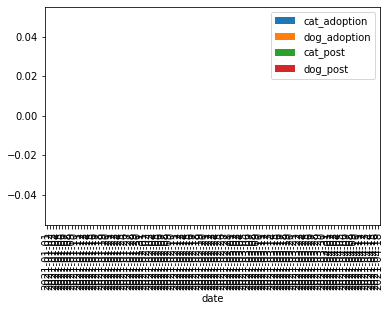

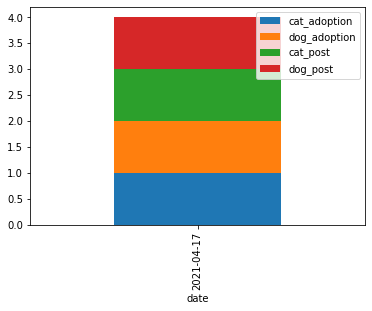

In [76]:
ax = daily_stats_df.groupby(['cat_adoption','dog_adoption']).plot.bar(stacked=True)